(8036, 66, 200, 3)


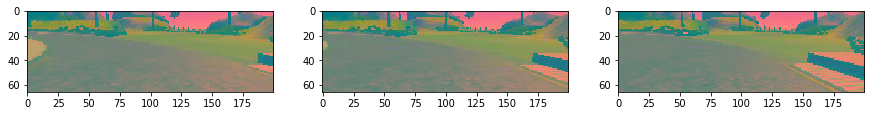

In [4]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

def clipped(im):
    h, w, _ = im.shape
    nh, nw = (h-66)//2, (w-200)//2
    im = im[nh:nh+66, nw:nw+200, :]
    return im

def extract_image(f):
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    im = clipped(im)
    #im = im[:,:,0]
    #mn, mx = np.min(im), np.max(im)
    #a, b = 0., 1.
    #im = a + ((im-mn)/(mx-mn))*(b-a)
    return im

def process_db(dir):
    with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
        data = pandas.read_csv(f, header=0, skipinitialspace=True)
        res = np.asarray(data.values)
        c, l, r, st, t, b, sp = np.split(res, 7, axis=1)
        l = np.array([extract_image(os.path.join(dir, p)) for p in l.squeeze()])
        c = np.array([extract_image(os.path.join(dir, p)) for p in c.squeeze()])
        r = np.array([extract_image(os.path.join(dir, p)) for p in r.squeeze()])        
        return l, c, r, st.squeeze()
        
l, c, r, st = process_db('./data')
print(c.shape)
%matplotlib inline
ix = 20
f = plt.figure(figsize=(15,8))
f.add_subplot(131).imshow((l[ix]), cmap='gray')
f.add_subplot(132).imshow((c[ix]), cmap='gray')
f.add_subplot(133).imshow((r[ix]), cmap='gray')

In [5]:
from sklearn.utils import shuffle

features = c
features = np.append(features, l, axis=0)
features = np.append(features, r, axis=0)

labels = st
labels = np.append(labels, st+0.25, axis=0)
labels = np.append(labels, st-0.25, axis=0)

print(features.shape, labels.shape)

#features, labels = shuffle(features, labels)
labels = labels.astype(np.float32)
#features = np.reshape(features, [-1, 160, 320, 1])

X_train, y_train = features, labels
print(X_train.shape, y_train.shape)



(24108, 66, 200, 3) (24108,)
(24108, 66, 200, 3) (24108,)


In [6]:
_ = plt.hist(st, 10)
plt.figure()
_ = plt.hist(labels, 10)

features = features.astype(np.float32)
mn = np.min(features, axis=(1,2,3), keepdims=True)
mx = np.max(features, axis=(1,2,3), keepdims=True)
rng = (mx - mn)
features -= mn
features = features/rng

print(features[0])

[[[ 0.90196079  0.4509804   0.5529412 ]
  [ 0.89019608  0.44705883  0.57254905]
  [ 0.90980393  0.44313726  0.57647061]
  ..., 
  [ 0.87058824  0.41176471  0.61176473]
  [ 0.9137255   0.42352942  0.57647061]
  [ 0.16862746  0.43529412  0.57254905]]

 [[ 0.48235294  0.49411765  0.4627451 ]
  [ 0.87450981  0.49019608  0.46666667]
  [ 0.90588236  0.48235294  0.4627451 ]
  ..., 
  [ 0.86666667  0.40784314  0.5529412 ]
  [ 0.92941177  0.41176471  0.5529412 ]
  [ 0.17254902  0.41960785  0.55686277]]

 [[ 0.34117648  0.48627451  0.51372552]
  [ 0.56078434  0.48235294  0.51372552]
  [ 0.90588236  0.47843137  0.50980395]
  ..., 
  [ 0.92941177  0.41960785  0.53725493]
  [ 0.9254902   0.41960785  0.53333336]
  [ 0.16862746  0.42352942  0.53333336]]

 ..., 
 [[ 0.44705883  0.52941179  0.4627451 ]
  [ 0.44705883  0.52941179  0.4627451 ]
  [ 0.44313726  0.52941179  0.4627451 ]
  ..., 
  [ 0.62352943  0.52549022  0.45882353]
  [ 0.58039218  0.52549022  0.45882353]
  [ 0.54901963  0.52549022  0.45882

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

def my_model():
    model = Sequential()
    model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu', name='c1', input_shape=(66, 200, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(64, name='d1',activation='relu'))
    model.add(Dense(32, name='d2',activation='linear'))
    model.add(Dense(16, name='d3',activation='relu'))
    model.add(Dense(1, name='d4', activation='linear'))
    
    return model


model = my_model()
model.compile('adam', 'mse', ['mse'])
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=2, validation_split=0.2)
y_pred = model.predict(X_train)



Train on 19286 samples, validate on 4822 samples
Epoch 1/10
43s - loss: 51.0442 - mean_squared_error: 51.0442 - val_loss: 0.0935 - val_mean_squared_error: 0.0935
Epoch 2/10
42s - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 3/10
42s - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 4/10
42s - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 5/10
42s - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0546 - val_mean_squared_error: 0.0546
Epoch 6/10
42s - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 7/10
42s - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0433 - val_mean_squared_error: 0.0433
Epoch 8/10
42s - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0607 - val_mean_squared_error: 0.0607
Epoch 9/10
42s - loss: 0.0173 - mean_squared_error: 0.0173 - 

In [10]:
print(np.column_stack((y_train, y_pred.squeeze())))
print(model.save("model.balanced.h5"))

[[ 0.          0.1870323 ]
 [ 0.          0.28225923]
 [ 0.         -0.02603806]
 ..., 
 [-0.25       -0.12694983]
 [-0.25       -0.11647981]
 [-0.25       -0.11957762]]
None


In [11]:
# balancing data
# different network model
# regularization
# all colour channels

# normalization it's own layer
